# Radar FMCW and CSM algorithms

This notebook shows a naive (didactically intuitive) implementation of following algorithms:

- FMCW (Frequency Modulated Continuous Wave)
- CSM (Chirp Sequence Modulation)

Both algorithms are used for range and velocity measurements in automated/assisted driving domain.

## Introduction

In order to understand what signal the algorithms operate on we have to take a closer look at the inner workings of a continuous wave radar (simplified view):

![cw-radar](cw-radar.png)

[Source](https://en.wikipedia.org/wiki/Continuous-wave_radar#/media/File:Bsp2_CW-Radar.EN.png)

### Antennas

The CW-RADAR has one transmitting antenna and at least one receiving antenna. The former emits a continuous radio wave, that's different to pulse-based RADAR systems. The receiving antenna transforms the reflected waves from the object of interests and converts the signal into eletrical domain (voltage).

Automotive long range radars use a $77.7\text{GHz}$ base frequency.

### RF-Generator

The RF-generator is a module which dynamically generates a sine voltage with a particular frequency. Since both methods presented here modulate (alter) the frequency of the tramitted radio wave, the generator is an essential part in the system.

### Mixer

The mixer is the most important component in the system described here. It allows us to measure the frequency change introduced by the moving object we are going to detect. We apply to the antenna the voltage $u_t(t)$ and receive the voltage $u_r(t)$.

\begin{align}
u_t(t) &= A_t \text{cos}(2\pi f_0 t+\phi_t) \\
u_r(t) &= A_r \text{cos}(2\pi (f_0 - f_{d}) t + \phi_r)
\end{align}

With Doppler frequency

\begin{align}
f_{d} = \frac{2v}{\lambda} = \frac{2 \dot r}{\lambda} = \frac{2 f_0 \dot r}{c}
\end{align}

Given base wavelength $\lambda$ and target velocity $v=\dot r$.

Theoretically, if we could sample $f_0 - f_{d} \approx 77.7GHz$ and we were done. But high frequency AD converters (according to Nyquist $\geq 2f_0 \approx 145GHz$ is required) are techinically expensive and the change introduced by $f_d$ is very small to detect changes. That's why we need the mixer to get rid of the high frequency $f_0$ and work only on the $f_d$. 

The mixer multiplies both signals, corresponding to trigonometry relations:

\begin{align}
\text{cos}(x)\text{cos}(y) = \frac{1}{2} [ \text{cos}(x-y) + \text{cos}(x+y)]
\end{align}

Applied to $u_t(t)$ and $u_r(t)$:

\begin{align}
u_t(t)u_r(t) &= \frac{A_t A_r}{2} [ \text{cos}(2\pi f_0 t+\phi_t-2\pi (f_0 - f_{d}) t - \phi_r) + \text{cos}(2\pi f_0 t+\phi_t+ 2\pi (f_0 - f_{d}) t + \phi_r)] \\
&= \frac{A_t A_r}{2} [ \text{cos}(2\pi f_{d} t + \phi_t - \phi_r) + \text{cos}(2\pi f_0 t+\phi_t + 2\pi (f_0- f_{d}) t + \phi_r)] \\
&= \frac{A_t A_r}{2} [ \text{cos}(2\pi f_{d} t + \phi_t - \phi_r) + \text{cos}(2\pi \underbrace{2 f_0}_{\text{2x 77GHz}} t - 2\pi f_{d}t + \phi_t + \phi_r)] \\
\end{align}

The product of both signals equals to a sum of two waves, the first, only dependent on the doppler frequency (which is velocity dependent) and the second a very high frequency signal (144 GHz) which we filter out with the low pass filter:

\begin{align}
u_{It,r}(t) = \frac{A_t A_r}{2} \text{cos}(2\pi f_{d} t + \phi_t - \phi_r)
\end{align}

After the AD converter we could sample $u_{It,r}(t)$ and measure the (unsigned) velocity. The index $I$ means in-phase. We later will introduce an other index in order to extract the sign of the velocity (approaching vs. departing).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft

Constant for velocity of light within the air:

In [3]:
c = 299792458

## FCMW

Instead of sending with one frequency, we will alternate $f_0$ over time:

\begin{align}
u_t(t) &= A_t \text{cos}(2\pi f_t t+\phi_t)
\end{align}

with 

\begin{align}
f_t = f_t(t) = f_0 + m_w(t-t_0)
\end{align}

In [4]:
f_0 = 77.7*1e9 # 77.7GHz

phi_t = 0
A_t = 1
f_ramp = 425*1e6 #Hz
T_ramp = 0.010
m_w = f_ramp/T_ramp

In [5]:
def f_t(t):
    return f_0 + m_w*(t % T_ramp)

In [6]:
def u_t(t):
    f_t = f_t(t)
    return A_t*np.cos(2*np.pi*f_b*t + phi_t)

The received signal depends on both the range $r$ and the velocity $v$:

\begin{align}
u_r(t) &= A_r \text{cos}(2\pi f_r t+\phi_r)
\end{align}

with 

\begin{align}
f_r = f_r(t) = f_0 + m_w(t- \frac{2r}{c}-t_0) - \frac{2vf_0}{c}
\end{align}

In [7]:
v = 50/3.6 # 50km/h
r = 100 # 100m distance

In [8]:
def f_r(t):
    return f_0 + m_w*(t % T_ramp - 2*r/c) - 2*v*f_0/c

In [9]:
t = np.arange(0, 2*T_ramp, 1e-8)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


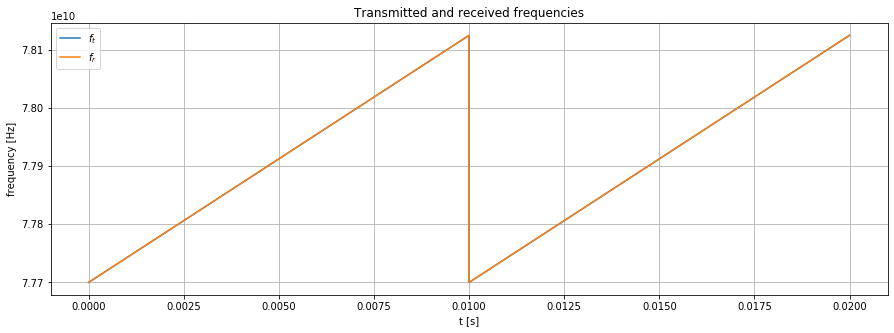

In [10]:
plt.figure(figsize=(15,5))
plt.plot(t, f_t(t), label="$f_t$")
plt.plot(t, f_r(t), label="$f_r$")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("Transmitted and received frequencies")
plt.grid();

Because we don't see any difference let's zoom in 

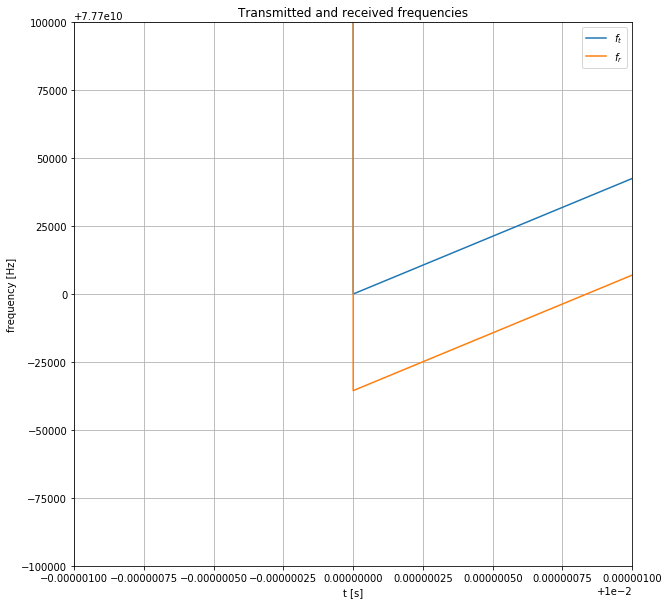

In [11]:
t_op = T_ramp
plt.figure(figsize=(10,10))
plt.plot(t, f_t(t), label="$f_t$")
plt.plot(t, f_r(t), label="$f_r$")
plt.legend()
plt.xlim([t_op-T_ramp/10000, t_op+T_ramp/10000])
plt.ylim([f_0-100e3, f_0+100e3])
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("Transmitted and received frequencies")
plt.grid();

If we could measure $\Delta f$ directly we could derive $r$ and $v$:

\begin{align}
\Delta f = f_t-f_r = \frac{2m_w}{c}r + \frac{2 f_0}{c}\dot r
\end{align}

There is just one problem. We have one equation but two unknowns. The solution for that problem is to have a second ramp with a different $m_w$:

\begin{align}
f_t(t) = \{\begin{array}{lr}
        f_0 + m_{w,1}(t-t_0), & \text{for } 0 \leq t < T_{r,1}\\
        f_0 + m_w T_{r,1} + m_{w,2}(t-t_0), & \text{for } T_{r,1} \leq t < T_{r,1}+T_{r,2}\
        \end{array}
\end{align}

Define and implement both waveforms:

In [12]:
T_ramp1 = T_ramp*0.7
T_ramp2 = T_ramp*0.3
m_w1 = f_ramp/T_ramp1
m_w2 = -f_ramp/T_ramp2

In [13]:
def f_t(t):
    r1 = f_0 + m_w1*(t % (T_ramp1+T_ramp2))
    r1[(t%(T_ramp1+T_ramp2)) > T_ramp1] = 0
    
    r2 = f_0 + m_w1*T_ramp1 + m_w2*( (t-T_ramp1) % (T_ramp1+T_ramp2))
    r2[(t%(T_ramp1+T_ramp2)) <= T_ramp1] = 0
    
    return r1+r2

In [14]:
def f_r(t):
    r1 = f_0 + m_w1*(t % (T_ramp1+T_ramp2) - 2*r/c) - 2*v*f_0/c
    r1[(t%(T_ramp1+T_ramp2)) > T_ramp1] = 0
    
    r2 = f_0 + m_w1*T_ramp1 + m_w2*( (t-T_ramp1) % (T_ramp1+T_ramp2) - 2*r/c) - 2*v*f_0/c
    r2[(t%(T_ramp1+T_ramp2)) <= T_ramp1] = 0
    return r1+r2

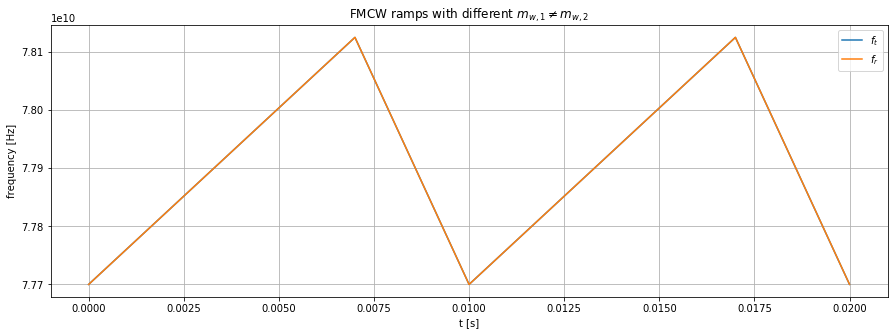

In [15]:
t = np.arange(0, 2*T_ramp, 1e-7)
plt.figure(figsize=(15,5))
plt.plot(t, f_t(t), label="$f_t$")
plt.plot(t, f_r(t), label="$f_r$")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("FMCW ramps with different $m_{w,1} \\neq m_{w,2}$")
plt.grid();

Zoom in again:

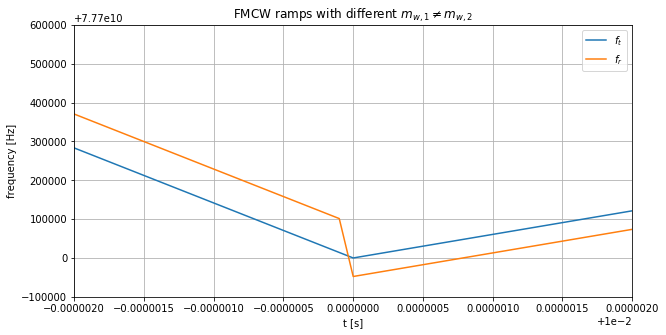

In [16]:
t_op = T_ramp
plt.figure(figsize=(10,5))
plt.plot(t, f_t(t), label="$f_t$")
plt.plot(t, f_r(t), label="$f_r$")
plt.legend()
plt.xlim([t_op-T_ramp/5000, t_op+T_ramp/5000])
plt.ylim([f_0-100e3, f_0+600e3])
plt.xlabel("t [s]")
plt.ylabel("frequency [Hz]")
plt.title("FMCW ramps with different $m_{w,1} \\neq m_{w,2}$")
plt.grid();

Now we have two equations:

\begin{align}
\Delta f_1 = \frac{2m_{w,1}}{c}r + \frac{2 f_0}{c}\dot r \\
\Delta f_2 = \frac{2m_{w,2}}{c}r + \frac{2 f_0}{c}\dot r
\end{align}

Solving the equation system:

In [17]:
t_f1 = np.asarray([T_ramp*0.1]) # beginning of rising ramp
t_f2 = np.asarray([T_ramp*0.8])  # beginning of falling ramp
delta_f_1 = f_t(t_f1) - f_r(t_f1)
delta_f_2 = f_t(t_f2) - f_r(t_f2)

In [18]:
A = np.asarray([[2*m_w1/c, 2*f_0/c], [2*m_w2/c, 2*f_0/c]])
Y = np.asarray([delta_f_1, delta_f_2])

In [19]:
x = np.linalg.solve(A, Y).flatten()
print("range r:", x[0])
print("velocity v:", x[1]*3.6)

range r: 99.99999999693145
velocity v: 49.99999988508472


As you could see we could successfully estimate the range and velocity.

**Note**: we get $\Delta f_i$ for free as a result of the FFT on the mixed and filtered signal 


\begin{align}
u_{It,r}(t) = \frac{A_t A_r}{2} \text{cos}(2\pi (f_t - f_r) t + \phi_t - \phi_r) = \frac{A_t A_r}{2} \text{cos}(2\pi \Delta f t + \phi_t - \phi_r)
\end{align}

In the FMCW chapter we did not address various problems like:

- multi target estimation (what happens if the FFT returns 2, 3, 4, ... major peaks?)
- angle estimation

# Model parameters

Chirp setup

In [20]:
f_chirp = 150*1e6 #Hz

# ramp frequency
f_r = 40*1e3 #Hz
T_r = 1/f_r

m_w = f_chirp/T_r
n_r = 300 # number of chirps
T_M = T_r*n_r

# sample settings
f_s = 20 * 1e6 #Hz
n_s = int(T_r*f_s)

In [21]:
print(n_s)

500


Base frequency setup

In [22]:
f_0 = 77.7*1e9
w_0 = 2*np.pi*f_0
c = 299792458

In [23]:
def f_transmitted(t):
    return f_0 + m_w*(t%T_r)

In [24]:
def chirp(t):
    return np.cos(2*np.pi*(f_transmitted(t))*t)

Lets visualize the chirp

In [25]:
t = np.linspace(0, 2*T_r, 1e6)

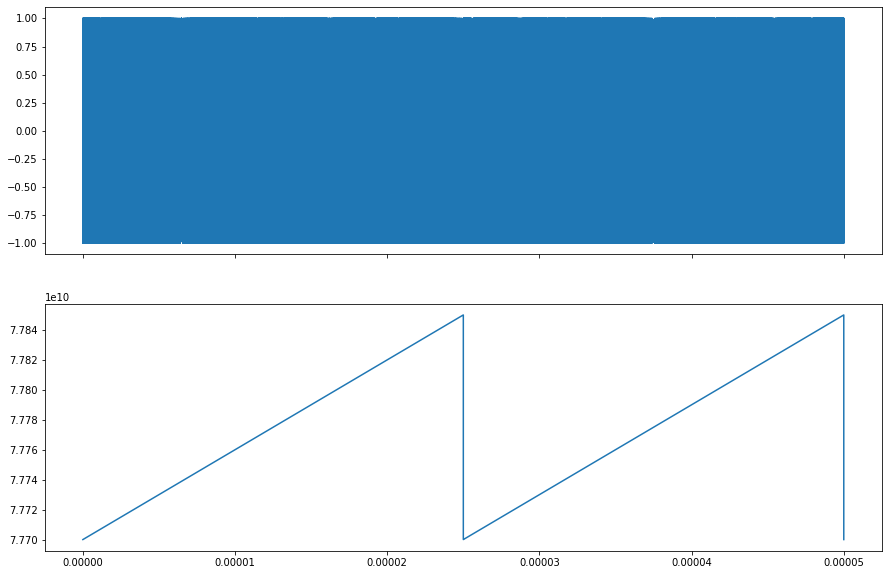

In [26]:
f, ax = plt.subplots(nrows=2, figsize=(15,10), sharex=True)
ax[0].plot(t, chirp(t))
ax[1].plot(t, f_transmitted(t))

Reflector setup

In [27]:
r_0 = 50 # initial distance
v_veh = 40/3.6 # velocity

In [28]:
def get_range(t):
    return r_0+v_veh*t

# Model

The model calculates the filtered mixed signal $u_{It,r}(t)$

In [29]:
def itr(t):
    r = get_range(t)
    w_itr = 2*f_0*v_veh/c + 2*m_w*r/c
    v = np.cos(w_itr*t +2*r*w_0/c + m_w*(2*r/c)**2)
    return v

In [30]:
2*v_veh*w_0/c/(2*np.pi)

5759.540043754759

In [31]:
r = get_range(0)
(2*f_0*v_veh/c + 2*m_w*r/c)/(2*np.pi)

319446.906800468

We build up a table of $n_r × n_s$ where $n_r$ is the number of chirps (ramps) and $n_s$ is the number of samples within a chirp.

In [32]:
t_sample = np.linspace(0, T_M, n_s*n_r)

In [33]:
t_sample.size

150000

In [34]:
v_sample = itr(t_sample)

(0, 2.5e-06)

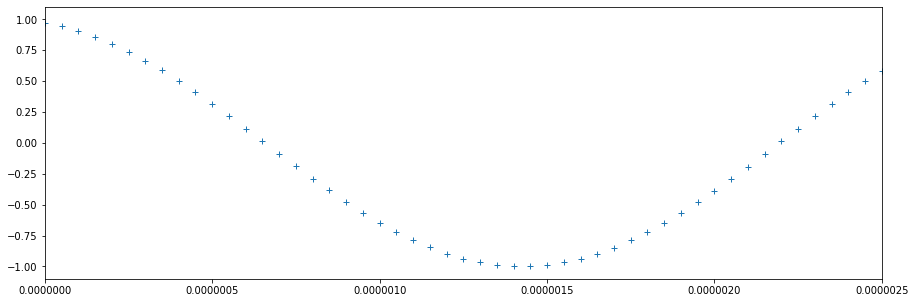

In [35]:
plt.figure(figsize=(15,5))
plt.plot(t_sample, v_sample, "+")
plt.xlim(0, 0.1*T_r)

In [36]:
table = np.zeros((n_r, n_s))

In [37]:
for chirp_nr in range(n_r):
    table[chirp_nr, :] = v_sample[chirp_nr*n_s:n_s*(chirp_nr+1)]

In [38]:
table_df = pd.DataFrame(data=table, columns=["sample_%03d"%i for i in range(n_s)], index=["chirp_%03d"%i for i in range(n_r)])

In [39]:
table_df.head()

,sample_000,sample_001,sample_002,sample_003,sample_004,sample_005,sample_006,sample_007,sample_008,sample_009,...,sample_490,sample_491,sample_492,sample_493,sample_494,sample_495,sample_496,sample_497,sample_498,sample_499
chirp_000,0.973893,0.945662,0.907569,0.860010,0.803483,0.738576,0.665966,0.586411,0.500740,0.409847,...,0.999668,0.991827,0.973641,0.945302,0.907103,0.859444,0.802822,0.737827,0.665136,0.585509
chirp_001,0.499775,0.408829,0.313620,0.215139,0.114415,0.012497,-0.089551,-0.190665,-0.289791,-0.385894,...,0.663903,0.584170,0.498343,0.407320,0.312048,0.213522,0.112769,0.010839,-0.091203,-0.192294
chirp_002,-0.291380,-0.387427,-0.479433,-0.566439,-0.647537,-0.721881,-0.788697,-0.847287,-0.897040,-0.937437,...,-0.093391,-0.194451,-0.293483,-0.389455,-0.481364,-0.568253,-0.649215,-0.723405,-0.790051,-0.848457
chirp_003,-0.898014,-0.938204,-0.968610,-0.988913,-0.998901,-0.998472,-0.987629,-0.966484,-0.935260,-0.894281,...,-0.791731,-0.849907,-0.899219,-0.939152,-0.969289,-0.989317,-0.999026,-0.998316,-0.987193,-0.965774
chirp_004,-0.934281,-0.893045,-0.842493,-0.783155,-0.715648,-0.640677,-0.559024,-0.471540,-0.379138,-0.282781,...,-0.986663,-0.964914,-0.933102,-0.891557,-0.840713,-0.781100,-0.713340,-0.638140,-0.556284,-0.468626


# FFT over the first chirp

In [40]:
chirp0_samples = table_df.iloc[0].values

In [41]:
chirp0_magnitude = fft(chirp0_samples)

In [42]:
frequencies = np.linspace(0, f_s/2, n_s//2)

In [43]:
frequencies/1000

array([    0.        ,    40.16064257,    80.32128514,   120.48192771,
         160.64257028,   200.80321285,   240.96385542,   281.12449799,
         321.28514056,   361.44578313,   401.6064257 ,   441.76706827,
         481.92771084,   522.08835341,   562.24899598,   602.40963855,
         642.57028112,   682.73092369,   722.89156627,   763.05220884,
         803.21285141,   843.37349398,   883.53413655,   923.69477912,
         963.85542169,  1004.01606426,  1044.17670683,  1084.3373494 ,
        1124.49799197,  1164.65863454,  1204.81927711,  1244.97991968,
        1285.14056225,  1325.30120482,  1365.46184739,  1405.62248996,
        1445.78313253,  1485.9437751 ,  1526.10441767,  1566.26506024,
        1606.42570281,  1646.58634538,  1686.74698795,  1726.90763052,
        1767.06827309,  1807.22891566,  1847.38955823,  1887.5502008 ,
        1927.71084337,  1967.87148594,  2008.03212851,  2048.19277108,
        2088.35341365,  2128.51405622,  2168.6746988 ,  2208.83534137,
      

each frequency is referred to a range

In [44]:
def freq_to_range(f):
    return 2*np.pi*f*c/(2*m_w)

50.43243821442714


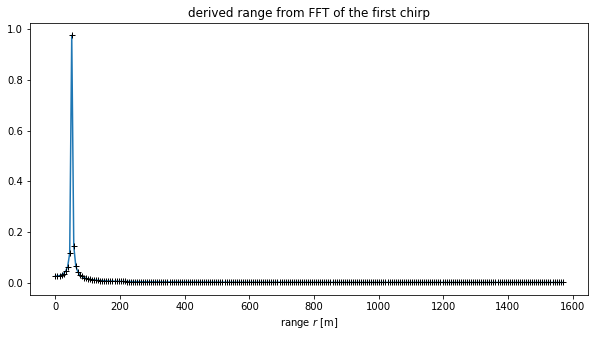

In [45]:
plt.figure(figsize=(10,5))
plt.plot(freq_to_range(frequencies), 2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]))
plt.plot(freq_to_range(frequencies), 2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]), "k+")
plt.xlabel("range $r$ [m]")
plt.title("derived range from FFT of the first chirp")
print(freq_to_range(frequencies)[np.argmax(2.0/n_s*np.abs(chirp0_magnitude[0:n_s//2]))])

Looks like we got the distance right

In [46]:
freq_to_range(frequencies)

array([   0.        ,    6.30405478,   12.60810955,   18.91216433,
         25.21621911,   31.52027388,   37.82432866,   44.12838344,
         50.43243821,   56.73649299,   63.04054777,   69.34460254,
         75.64865732,   81.9527121 ,   88.25676688,   94.56082165,
        100.86487643,  107.16893121,  113.47298598,  119.77704076,
        126.08109554,  132.38515031,  138.68920509,  144.99325987,
        151.29731464,  157.60136942,  163.9054242 ,  170.20947897,
        176.51353375,  182.81758853,  189.1216433 ,  195.42569808,
        201.72975286,  208.03380763,  214.33786241,  220.64191719,
        226.94597196,  233.25002674,  239.55408152,  245.8581363 ,
        252.16219107,  258.46624585,  264.77030063,  271.0743554 ,
        277.37841018,  283.68246496,  289.98651973,  296.29057451,
        302.59462929,  308.89868406,  315.20273884,  321.50679362,
        327.81084839,  334.11490317,  340.41895795,  346.72301272,
        353.0270675 ,  359.33112228,  365.63517705,  371.93923

# Calculate range bins for each chirp

In [47]:
range_table = np.zeros((n_r, n_s//2), dtype=np.csingle)

In [48]:
for chirp_nr in range(n_r):
    chirp_ad_values = table_df.iloc[chirp_nr].values
    chirp_fft = fft(chirp_ad_values)
    range_table[chirp_nr, :] = 2.0/n_s*chirp_fft[:n_s//2]

Let's visualize the table

Text(0.5, 1.0, 'Imag{$A(j\\omega)$}')

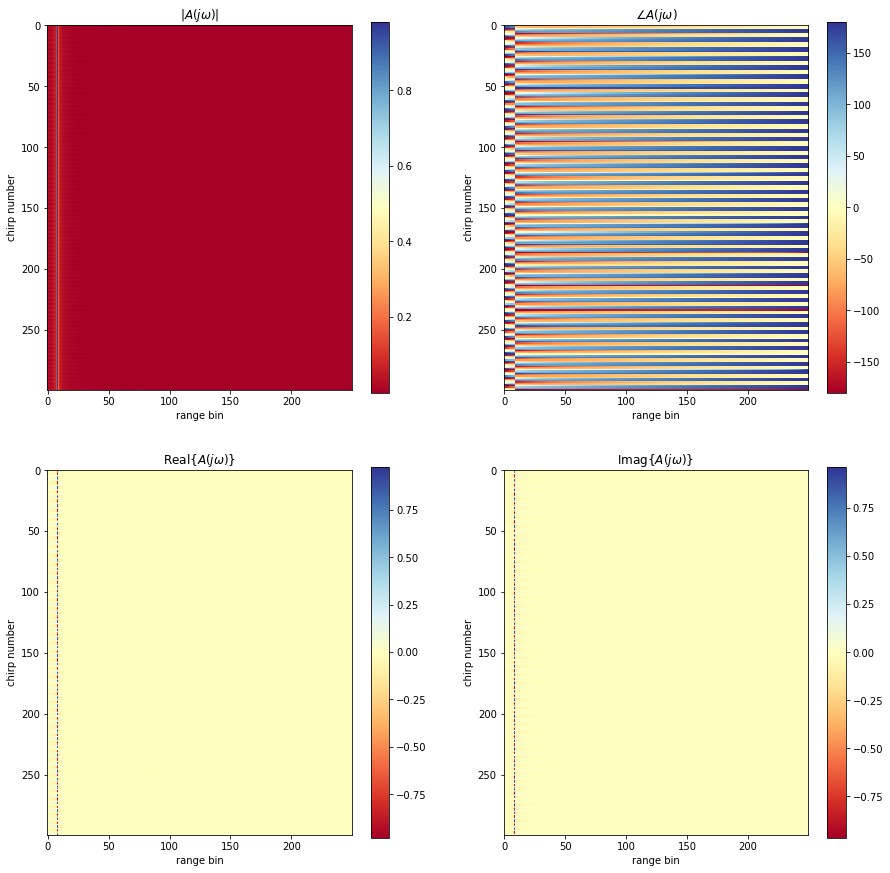

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
abs_axes = ax[0, 0]
phi_axes = ax[0, 1]
real_axes = ax[1, 0]
imag_axes = ax[1, 1]

im_asb = abs_axes.imshow(np.abs(range_table), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_asb, ax=abs_axes)
abs_axes.set_xlabel("range bin")
abs_axes.set_ylabel("chirp number")
abs_axes.set_title("$|A(j\omega)|$")

im_phi = phi_axes.imshow(np.angle(range_table)*360/(2*np.pi), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_phi, ax=phi_axes)
phi_axes.set_xlabel("range bin")
phi_axes.set_ylabel("chirp number")
phi_axes.set_title("$∠ A(j\omega)$")

im_real = real_axes.imshow(np.real(range_table), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_real, ax=real_axes)
real_axes.set_xlabel("range bin")
real_axes.set_ylabel("chirp number")
real_axes.set_title("Real{$A(j\omega)$}")

im_imag = imag_axes.imshow(np.imag(range_table), cmap = plt.get_cmap('RdYlBu'))
fig.colorbar(im_imag, ax=imag_axes)
imag_axes.set_xlabel("range bin")
imag_axes.set_ylabel("chirp number")
imag_axes.set_title("Imag{$A(j\omega)$}")

Let's look into phase change in the bin 16

In [50]:
chirp0_angle = np.angle(range_table)[-4, 8]
chirp1_angle = np.angle(range_table)[-3, 8]
print(chirp0_angle, chirp1_angle)

-2.9259925 -1.9467837


In [51]:
def angle_to_distance(a):
    return a*c/(w_0*2)

In [52]:
r0 = angle_to_distance(chirp0_angle)
r1 = angle_to_distance(chirp1_angle)
print(r0, r1)

-0.0008983861066725217 -0.0005977333848785745


In [53]:
(r1-r0)/T_r

12.026108871757888

In [54]:
50/3.6

13.88888888888889

## Velocity estimation

We make a second FFT over each range bin (column)

In [55]:
velocity_table = np.zeros((n_r//2, range_table.shape[1]), dtype=np.csingle)

In [56]:
for r in range(range_table.shape[1]):
    range_bin_magn = range_table[:, r]
    range_bin_fft = fft(range_bin_magn)
    velocity_table[:, r]= 2.0/n_r*range_bin_fft[:n_r//2]

In [57]:
velocity_table_abs = np.abs(velocity_table)

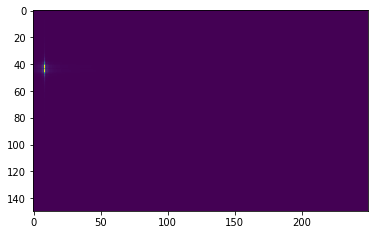

In [58]:
plt.imshow(velocity_table_abs)

In [59]:
ranges = freq_to_range(np.linspace(0, f_s/2, n_s//2))

In [60]:
def freq_to_velocity(f):
    return 2*np.pi*f*c/(2*w_0)

In [61]:
velocities = freq_to_velocity(np.linspace(0, f_r//2, n_r//2))

(41, 8)


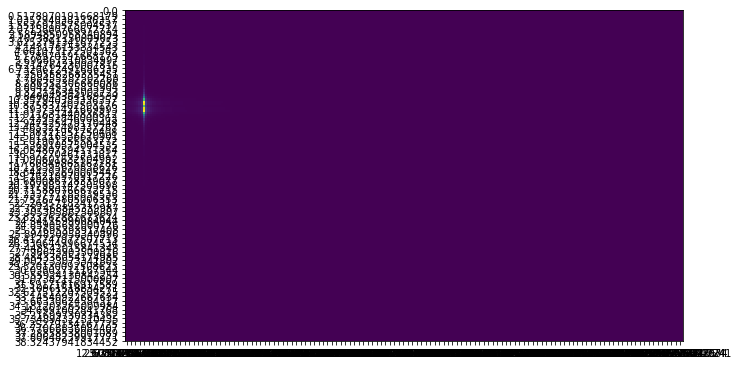

In [62]:
plt.figure(figsize=(10,20))
plt.imshow(velocity_table_abs)
plt.yticks(range(n_r//2)[::2], velocities[::2])
plt.xticks(range(n_s//2)[::2], ranges[::2])

ind = np.unravel_index(np.argmax(velocity_table_abs, axis=None), velocity_table_abs.shape)
print(ind)

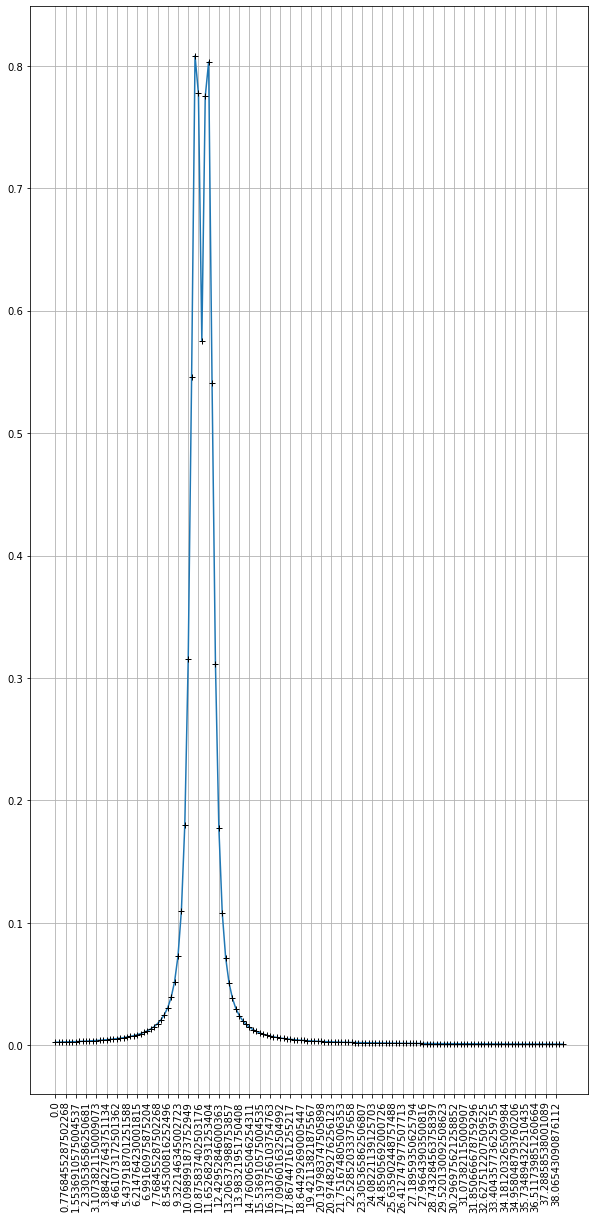

In [63]:
plt.figure(figsize=(10,20))
plt.plot(velocity_table_abs[:, ind[1]])
plt.plot(velocity_table_abs[:, ind[1]], "k+")
plt.xticks(range(n_r//2)[::3], velocities[::3]);
plt.xticks(rotation=90);
plt.grid();

In [64]:
velocity_table_abs.shape

(150, 250)

In [65]:
v_res = c/(2*T_M*f_0)
print(v_res)

0.2572221861861862


In [66]:
v_veh

11.11111111111111